# Molecular Biology - Exact and approximate string matching
## Exact and approximate edit distance computation (with and without cut-off threshold) in DNA strings
## We use DNA strings of length up to $10,000$ characters.

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from functools import partial
from multiprocessing import Pool

%matplotlib inline

Let's define some functions for random strings creation and storing in a file.

<b>CreateFile</b> creates a file in which all the randomly created strings will be stored.

<b>CreateRandStr</b> creates a random string with the specified length using characters of the specified alphabet.

In [3]:
def CreateFile(filePath, lengths, maxStringsPerLength, alphabet):
    file = open(filePath,'w')
    
    for length in lengths:
        for i in range(maxStringsPerLength):
            string = CreateRandStr(length, alphabet)
            string += ','
            string += CreateRandStr(length, alphabet)
            file.write(string + '\n')
    
    file.close()

def CreateRandStr(str_len, alphabet='ACGT'):
    # create an empty stringEditDistance
    rand_str = ""
    
    # how many characters of the string we have determined so far
    chr_cnt = 0
    
    while chr_cnt < str_len:
        rand_str = rand_str + alphabet[random.randint(0,len(alphabet)-1)]
        chr_cnt = chr_cnt + 1
    return rand_str

Let's initialize all the common variables that we are going to use and create the file with the random strings as well as logging.

<b>Note</b>: we are going to compute edit distances in strings of $5\cdot2,000 + 5\cdot4,000 + 5\cdot6,000 + 5\cdot8,000 + 5\cdot10,000 = 150,000$ characters in total.

In [4]:
# intitialize & configure logging
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")


# the string lengths that we are going to use
a=2000
lengths = list(range(a,6*a,a))
print('Using strings of lengths: ' + ', '.join(str(l) for l in lengths))


# maximum number of strings per string length, strings alphabet and file name
maxStringsPerLength = 5
alphabet = 'ACGT'
filename = 'strings.txt'


# create random strings - use it if no strings file is available
CreateFile(filename, lengths, maxStringsPerLength, alphabet)

Using strings of lengths: 2000, 4000, 6000, 8000, 10000


### Part 1: Exact edit distance
#### The implementation of EditDistance calculation is based on the dynamic programming paradigm, utilizing both recursion and a matrix for storing the calculated paths.

The dynamic programming matrix is initialized with NaN values instead of zeros (to help in counting the number of the dynamic programming matrix cells filled for the edit distance calculation)

The function returns a tuple (y, number) where y is the edit distance and number is the number of the dynamic programming matrix cells filled for the edit distance calculation.

<b>Note</b>: Filled dynamic programming matrix cells are those whose values are not equal to NaN

In [5]:
def EditDistance(s, t):  
    size_x = len(s) + 1
    size_y = len(t) + 1
    
    matrix = np.empty((size_x, size_y))
    matrix[:] = np.nan
    
    for x in range(size_x):
        matrix[x, 0] = x
    for y in range(size_y):
        matrix[0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if s[x-1] == t[y-1]:
                matrix[x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix[x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
                
    edited = np.count_nonzero(~np.isnan(matrix))
    
    return (matrix[size_x-1, size_y-1], edited)


def calculate_edit_distances(filename, lengths, maxStringsPerLength):
    times = []
    nonzeros = []
    
    file = open(filename, 'r')
    
    totaltime = 0
    time = 0
    temp_nonzeros = []
    count = 0
    index = 0
    length = lengths[index]
    
    logging.info(f"Calculating edit distances in strings of length {length} without cut-off threshold")

    for line in file:
        text = line.strip().split(',')
        
        string1 = text[0]
        string2 = text[1]
        
        if len(string1) != length and len(string2) != length:
            continue

        start=timeit.default_timer()
        result = EditDistance(string1,string2)
        stop=timeit.default_timer()
        time += stop-start
        temp_nonzeros.append(result[1])

        count += 1

        if (count == maxStringsPerLength):
            times.append(time/count)
            nonzeros.append(round(sum(temp_nonzeros)/len(temp_nonzeros)))
            
            totaltime += time
            time = 0
            temp_nonzeros = []
            count = 0
            index += 1

            if index < len(lengths):
                length = lengths[index]
                logging.info(f"Calculating edit distances in strings of length {length} without cut-off threshold")
            else:
                break
    
    file.close()
    
    logging.info(f"Calculations complete")
    
    return (totaltime, times, nonzeros)

#### Compute the edit distance in the random strings, using EditDistance.

In [6]:
# perform calculations
totaltime, cedtimes, cednonzeros = calculate_edit_distances(filename, lengths, maxStringsPerLength)

# present total calculations time
print(f"EditDistance time (seconds): {int(round(totaltime,0))}")

17:55:11: Calculating edit distances in strings of length 2000 without cut-off threshold
17:55:59: Calculating edit distances in strings of length 4000 without cut-off threshold
17:59:13: Calculating edit distances in strings of length 6000 without cut-off threshold
18:19:20: Calculating edit distances in strings of length 10000 without cut-off threshold
18:39:23: Calculations complete


EditDistance time (seconds): 2652


### Part 2: Approximate edit distance
#### The implementation of EditDistanceCutOff calculation is based on the dynamic programming paradigm, utilizing both recursion and a matrix for storing the calculated paths, following Ukkonen’s cut-off algorithm, as it was presented in the slides created by Dr. Juha Kärkkäinen for the course String Processing Algorithms, tought in the University of Helsinki in fall 2015.

The dynamic programming matrix is initialized with NaN values instead of zeros (to help in counting the number of the dynamic programming matrix cells filled for the edit distance calculation)

The function returns a tuple (y, count) where y is the output of the Ukkonen algorithm and count is the number of the dynamic programming matrix cells filled for the edit distance calculation.

<b>Note</b>: Filled dynamic programming matrix cells are those whose values are not equal to NaN

In [7]:
def EditDistanceCutOff(text, pattern, k):
    if text == pattern:
        return (0, 0)
    
    n = len(text)
    m = len(pattern)
    
    if n < m:
        text, pattern = pattern, text
        n, m = m, n
    
    size_x = m + 1
    size_y = n + 1
    
    matrix = np.empty((size_x, size_y))
    matrix[:] = np.nan
    
    top = min(k+1, m)
    
    for x in range(0,top+1):
        matrix[x, 0] = x
    for y in range(0,size_y):
        matrix[0,y] = 0
    
    final_y = 0
    for y in range(1, size_y):
        for x in range(1, top+1):
            if pattern[x-1] == text[y-1]:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1] + 1,
                    matrix[x, y-1] + 1
                )
        while matrix[top, y] > k:
            top = top - 1
        if top == m:
            final_y = y
        else:
            top += 1
            matrix[top, y] = k+1

    edited = np.count_nonzero(~np.isnan(matrix))
    
    return (final_y, edited)


def calculate_edit_distances_cutoff(filename, lengths, maxStringsPerLength, k):
    times = []
    nonzeros = []
    
    file = open(filename, 'r')
    
    totaltime = 0
    time = 0
    temp_nonzeros = []
    count = 0
    index = 0
    length = lengths[index]
    
    logging.info(f"Calculating edit distances in strings of length {length} with cut-off threshold {k}")

    for line in file:
        text = line.strip().split(',')
        
        string1 = text[0]
        string2 = text[1]
        
        if len(string1) != length and len(string2) != length:
            continue

        start=timeit.default_timer()
        result = EditDistanceCutOff(string1,string2,k)
        stop=timeit.default_timer()
        time += stop-start
        temp_nonzeros.append(result[1])

        count += 1

        if (count == maxStringsPerLength):
            times.append(time/count)
            nonzeros.append(round(sum(temp_nonzeros)/len(temp_nonzeros)))
            
            totaltime += time
            time = 0
            temp_nonzeros = []
            count = 0
            index += 1

            if index < len(lengths):
                length = lengths[index]
                logging.info(f"Calculating edit distances in strings of length {length} with cut-off threshold {k}")
            else:
                break
    
    file.close()
    
    logging.info(f"Calculations complete")
    
    return (totaltime, times, nonzeros)


def calculate_edit_distances_cutoff_klist(filename, lengths, maxStringsPerLength, klist):
    times = []
    nonzeros = []
    
    file = open(filename, 'r')
    
    totaltime = 0
    time = 0
    temp_nonzeros = []
    count = 0
    index = 0
    length = lengths[index]
    k = klist[index]
    
    logging.info(f"Calculating edit distances in strings of length {length} with cut-off threshold {k}")

    for line in file:
        text = line.strip().split(',')
        
        string1 = text[0]
        string2 = text[1]
        
        if len(string1) != length and len(string2) != length:
            continue

        start=timeit.default_timer()
        result = EditDistanceCutOff(string1,string2,k)
        stop=timeit.default_timer()
        time += stop-start
        temp_nonzeros.append(result[1])

        count += 1
        
        if (count == maxStringsPerLength):
            times.append(time/count)
            nonzeros.append(round(sum(temp_nonzeros)/len(temp_nonzeros)))
            
            totaltime += time
            time = 0
            temp_nonzeros = []
            count = 0
            index += 1

            if index < len(lengths):
                length = lengths[index]
                k = klist[index]
                logging.info(f"Calculating edit distances in strings of length {length} with cut-off threshold {k}")
            else:
                break
    
    file.close()
    
    logging.info(f"Calculations complete")
    
    return (totaltime, times, nonzeros)

#### Experiment #1: we use $k=100$ as a global cut-off threshold for every string, not matter what its length is.

In [8]:
k = 100

# perform calculations
totaltime, cedctimes, cedcnonzeros = calculate_edit_distances_cutoff(filename, lengths, maxStringsPerLength, k)
    

# present total computation time
print(f"EditDistanceCutOff time (seconds) with k={k}: {int(round(totaltime))}")

18:39:23: Calculating edit distances in strings of length 2000 with cut-off threshold 100
18:39:28: Calculating edit distances in strings of length 4000 with cut-off threshold 100
18:39:37: Calculating edit distances in strings of length 6000 with cut-off threshold 100
18:39:52: Calculating edit distances in strings of length 8000 with cut-off threshold 100
18:40:13: Calculating edit distances in strings of length 10000 with cut-off threshold 100
18:40:38: Calculations complete


EditDistanceCutOff time (seconds) with k=100: 75


#### Results

Let's plot the time difference and the difference in the count of filled matrix cells between the EditDistance and EditDistanceCutOff.

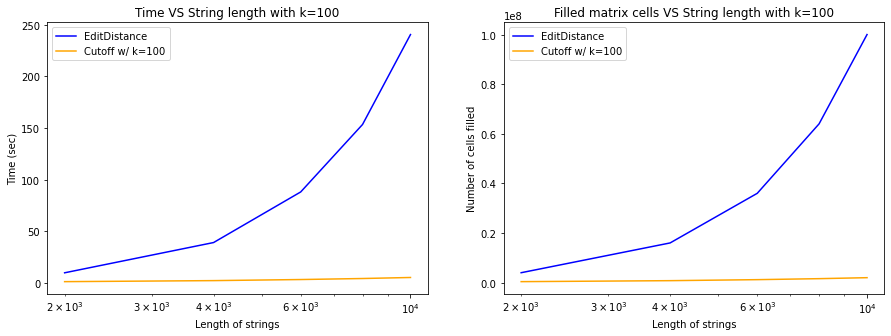

In [9]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1, 2, 1)
plt.xlabel('Length of strings')
plt.ylabel('Time (sec)')
plt.title(f'Time VS String length with k={k}')
plt.xscale("log")
plt.plot(lengths, cedtimes, color='blue', label='EditDistance')
plt.plot(lengths, cedctimes, color='orange', label=f'Cutoff w/ k={k}')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Length of strings')
plt.ylabel('Number of cells filled')
plt.title(f'Filled matrix cells VS String length with k={k}')
plt.xscale("log")
plt.plot(lengths, cednonzeros, color='blue', label='EditDistance')
plt.plot(lengths, cedcnonzeros, color='orange', label=f'Cutoff w/ k={k}')
plt.legend()

plt.show()

It is obvious that the classic Edit Distance algorithm is much slower than Ukkonen's algorithm, as using the former the computation time increases exponentially with the length of the strings, while using the latter the computation time was almost constant.

Also, using the classic Edit Distance algorithm, the number of filled cells in the dynamic programming matrix increases exponentially with the length of the strings, where using the Ukkonen's algorithm this number was almost constant and really close to zero regardless of the length of the strings, which means that Ukkonen's algorithm modifies a really small number of cells in the distance matrix.

#### Experiment #2: we are going to use values for the cut-off threshold $k$ based on the length of the strings.

More specifically, we are going to use percentages of the length of the strings, starting from 10% going up to 50% which is half the length of the string.

Based on the length of the strings, we create a list of cut-off thresholds and use each one for the respective string length

For each percentage, we plot the time difference and the difference in the count of filled matrix cells between the two computation methods.

18:40:39: Calculating edit distances in strings of length 2000 with cut-off threshold 200
18:40:48: Calculating edit distances in strings of length 4000 with cut-off threshold 400
18:41:25: Calculating edit distances in strings of length 6000 with cut-off threshold 600
18:42:49: Calculating edit distances in strings of length 8000 with cut-off threshold 800
18:45:21: Calculating edit distances in strings of length 10000 with cut-off threshold 1000
18:49:22: Calculations complete


EditDistanceCutOff time (seconds) with k=10% of the string's length: 523


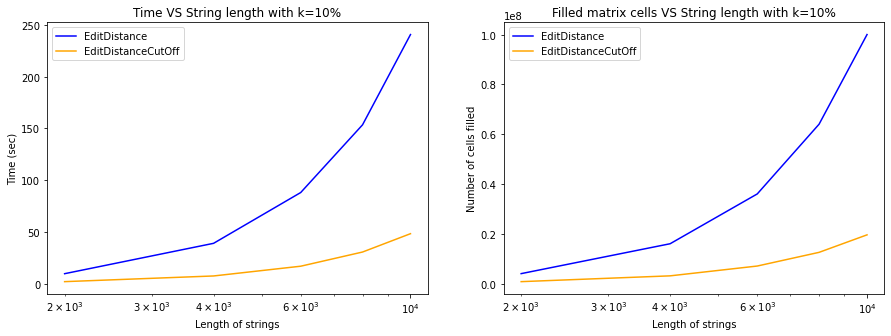

18:49:23: Calculating edit distances in strings of length 2000 with cut-off threshold 400


------------------------------------------------------------------------------------------------------------------------------------------------------


18:49:42: Calculating edit distances in strings of length 4000 with cut-off threshold 800
18:51:02: Calculating edit distances in strings of length 6000 with cut-off threshold 1200
18:53:58: Calculating edit distances in strings of length 8000 with cut-off threshold 1600
18:59:25: Calculating edit distances in strings of length 10000 with cut-off threshold 2000
19:07:48: Calculations complete


EditDistanceCutOff time (seconds) with k=20% of the string's length: 1105


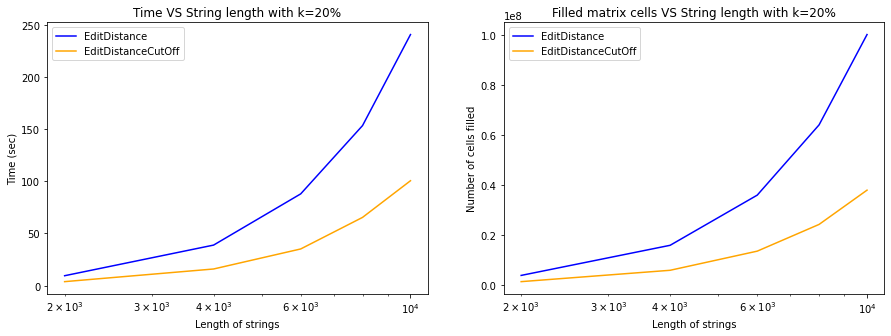

19:07:49: Calculating edit distances in strings of length 2000 with cut-off threshold 600


------------------------------------------------------------------------------------------------------------------------------------------------------


19:08:16: Calculating edit distances in strings of length 4000 with cut-off threshold 1200
19:10:09: Calculating edit distances in strings of length 6000 with cut-off threshold 1800
19:14:26: Calculating edit distances in strings of length 8000 with cut-off threshold 2400
19:22:21: Calculating edit distances in strings of length 10000 with cut-off threshold 3000
19:35:38: Calculations complete


EditDistanceCutOff time (seconds) with k=30% of the string's length: 1669


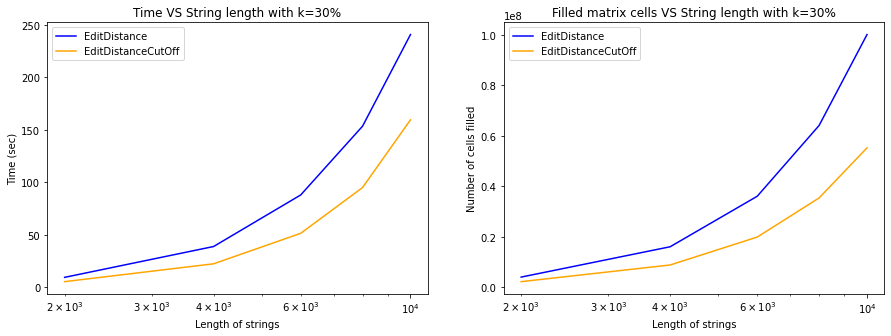

19:35:39: Calculating edit distances in strings of length 2000 with cut-off threshold 800


------------------------------------------------------------------------------------------------------------------------------------------------------


19:36:16: Calculating edit distances in strings of length 4000 with cut-off threshold 1600
19:38:45: Calculating edit distances in strings of length 6000 with cut-off threshold 2400
19:44:32: Calculating edit distances in strings of length 8000 with cut-off threshold 3200
19:54:51: Calculating edit distances in strings of length 10000 with cut-off threshold 4000
20:11:06: Calculations complete


EditDistanceCutOff time (seconds) with k=40% of the string's length: 2127


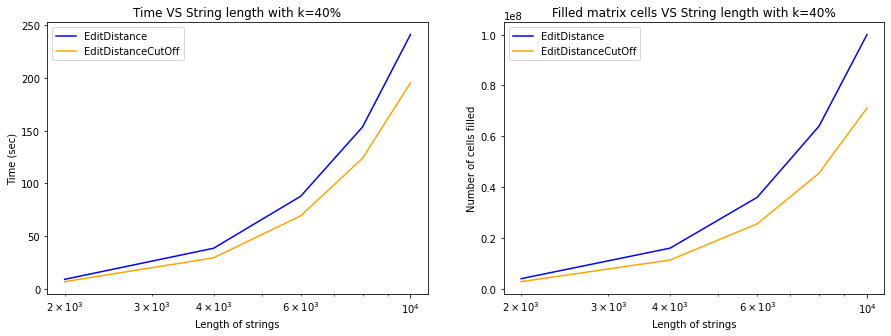

20:11:07: Calculating edit distances in strings of length 2000 with cut-off threshold 1000


------------------------------------------------------------------------------------------------------------------------------------------------------


20:11:50: Calculating edit distances in strings of length 4000 with cut-off threshold 2000
20:14:45: Calculating edit distances in strings of length 6000 with cut-off threshold 3000
20:21:28: Calculating edit distances in strings of length 8000 with cut-off threshold 4000
20:33:54: Calculating edit distances in strings of length 10000 with cut-off threshold 5000
20:53:34: Calculations complete


EditDistanceCutOff time (seconds) with k=50% of the string's length: 2547


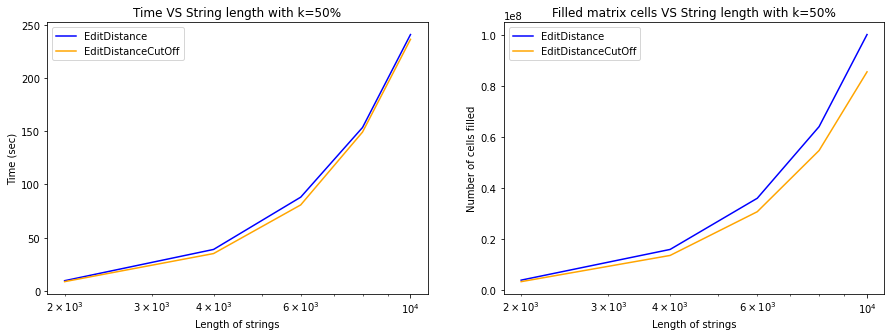

------------------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
for i in range(1,6):
    p = float(i)/10.0
    
    thresholds = [math.ceil(float(i)/10.0*l) for l in lengths]
    
    # perform calculations
    totaltime, cedctimes, cedcnonzeros = calculate_edit_distances_cutoff_klist(filename, lengths, maxStringsPerLength, thresholds)
    
    
    # present total computation time
    print(f"EditDistanceCutOff time (seconds) with k={int(100*p)}% of the string's length: {int(round(totaltime))}")
    
    
    # plot the results
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.xlabel('Length of strings')
    plt.ylabel('Time (sec)')
    plt.title(f'Time VS String length with k={int(100*p)}%')
    plt.xscale("log")
    plt.plot(lengths, cedtimes, color='blue', label='EditDistance')
    plt.plot(lengths, cedctimes, color='orange', label=f'EditDistanceCutOff')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Length of strings')
    plt.ylabel('Number of cells filled')
    plt.title(f'Filled matrix cells VS String length with k={int(100*p)}%')
    plt.xscale("log")
    plt.plot(lengths, cednonzeros, color='blue', label='EditDistance')
    plt.plot(lengths, cedcnonzeros, color='orange', label=f'EditDistanceCutOff')
    plt.legend()
    
    plt.show()
    
    print('-' * 150)

It is obvious that for small values of the cut-off threshold k compared to the length of the strings in comparison, the classic Edit Distance algorithm is much slower than Ukkonen's algorithm and produces more filled cells in the dynamic programming matrix.

However, as the value of $k$ increases and approaches the length of the strings, both the computation time and the number of filled cells in the dynamic programming matrix of the Ukkonen's algorithm increases, approximating the results of the classic Edit Distance algorithm.